In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy as sc
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings("ignore")

plt.style.use('./plot_script/mplstyle_czi')
import sys
sys.path.insert(0, './plot_script/')
import cziplot
dpi=150

In [2]:
# meta data
cluster_meta=pd.read_csv('../data/TableS7-cell_metadata.csv.gz',index_col=0).dropna()
cluster_meta['age']=cluster_meta['donor'].str[0]
cluster_meta['sex']=cluster_meta['donor'].str[1]
print(cluster_meta.shape)
gene_meta=pd.read_csv('../data/gencode.v37.annotation.intragenic.bed.gz',
                      names=['chr','start','end','gene_id','strand','tmp','gene_name','fn'],
                      index_col='gene_id', sep='\t')
gene_meta['len']=gene_meta['end']-gene_meta['start']
gene_meta=gene_meta[~gene_meta['chr'].isin(['chrY','chrM'])]
genedict_nametoid=dict(zip(gene_meta.gene_name, gene_meta.index))
genedict_idtoname=dict(zip(gene_meta.index, gene_meta.gene_name))
level2_order=cziplot.level2_order
level2_palette=cziplot.level2_palette

(54779, 22)


# cell type composition

RanksumsResult(statistic=-2.556038601690775, pvalue=0.010587137334056945)


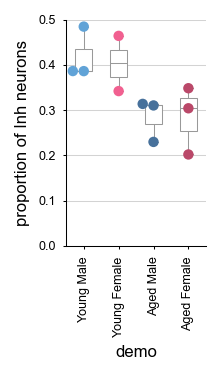

In [3]:
level='level0'
df=cluster_meta[(cluster_meta[level]!='Glia')].groupby(['donor',level,'age']).size().reset_index()
df.columns=['donor',level,'demo','number']
df=df.pivot(index='donor',columns='level0',values='number')
df['Neuron']=df['Exc']+df['Inh']
df['Inh ratio']=df['Inh']/df['Neuron']
df['age']=df.index.str[0]

df['demo']=df.index.str[0:2]
plt.figure(figsize=(1.2,2),dpi=150)
sns.boxplot(x='demo',y='Inh ratio',data=df,order=['YM','YF','AM','AF'],palette=['white','white','white','white'],width=0.5)
sns.swarmplot(x='demo',y='Inh ratio',data=df,order=['YM','YF','AM','AF'],palette=['#61a3d7','#f16090','#47719b','#ba4869'])
plt.ylabel('proportion of Inh neurons')
plt.xticks([0,1,2,3],['Young Male','Young Female','Aged Male','Aged Female'])
plt.ylim([0,0.5])
plt.xticks(rotation=90)
plt.grid(axis='y')
print(sc.stats.ranksums(df[df['age']=='A']['Inh ratio'],df[df['age']=='Y']['Inh ratio']))

,fdr
MGE_SST,0.064784
CGE_LAMP5_LHX6,0.064784
L4-5IT_RORB_ARHGAP15,0.074110
CGE_VIP,0.092516
MGE_PVALB_COL15A1,0.119531
L4-5IT_RORB_LRRK1,0.156134
L6IT_THEMIS_LINC00343,0.178209
L6b_TLE4_NXPH4,0.178209
L6CT_TLE4_FAM95C,0.191574
L4-5IT_RORB_TSHZ2,0.191574


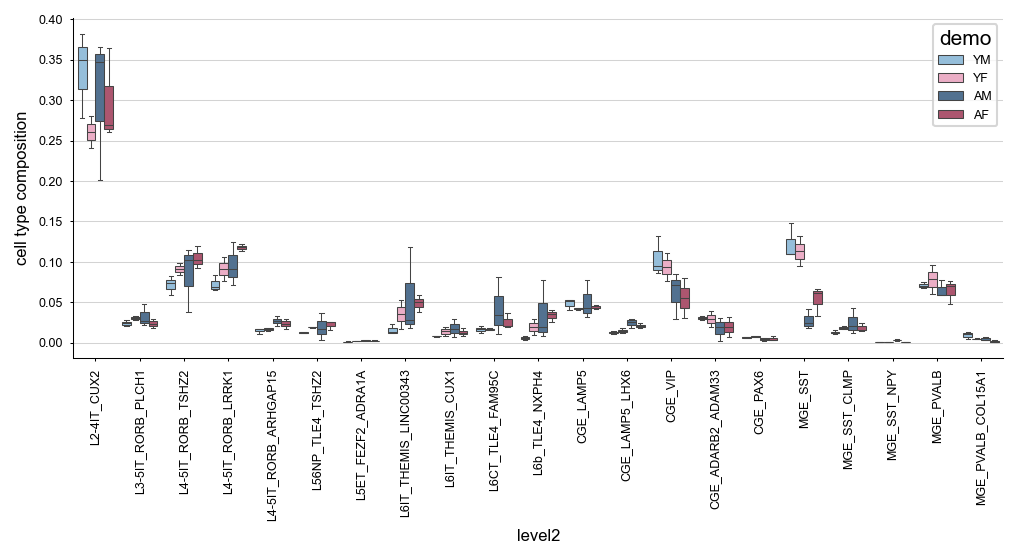

In [4]:
level='level2'
cluster_meta['demo']=cluster_meta['age']+cluster_meta['sex']
celltype_donor_size=cluster_meta[~(cluster_meta[level].str.contains('Glia'))].groupby('donor').size().to_frame('counts')
celltype_donor_size_dic=dict(zip(celltype_donor_size.index, celltype_donor_size.counts))
df=cluster_meta[~(cluster_meta[level].str.contains('Glia'))].groupby(['donor',level,'demo']).size().reset_index()
df.columns=['donor',level,'demo','number']
df['totalcounts']=df['donor'].map(celltype_donor_size_dic)
df['ratio']=df['number']/df['totalcounts']

plt.figure(figsize=(8,3),dpi=dpi)
sns.boxplot(x=level,y='ratio',data=df,hue='demo',hue_order=cziplot.demo_order,order=cziplot.level2_order_full[0:-3],showfliers=False,
              palette=cziplot.demo_palette,
             linewidth=0.5)
plt.xticks(rotation=90)
plt.ylabel('cell type composition')
plt.grid(axis='y')
pall=[]
for i in cziplot.level2_order_full[0:-3]:
    s,p=sc.stats.ranksums(df[(df['demo'].isin(['AM','AF']))&(df[level]==i)]['ratio'],df[(df['demo'].isin(['YM','YF']))&(df[level]==i)]['ratio'])
    pall.append(p)
    if (p < 0.05) & (s<1):
        r=df[(df['demo'].isin(['YM','YF']))&(df[level]==i)]['ratio'].mean()/df[(df['demo'].isin(['AM','AF']))&(df[level]==i)]['ratio'].mean()
    if (p < 0.05) & (s>1):
        r=df[(df['demo'].isin(['AM','AF']))&(df[level]==i)]['ratio'].mean()/df[(df['demo'].isin(['YM','YF']))&(df[level]==i)]['ratio'].mean()
fdr=fdrcorrection(pall,method='poscorr')
pd.DataFrame(index=cziplot.level2_order_full[0:-3],columns=['fdr'],data=fdr[1]).sort_values('fdr')

# Num. of ageDEs and ageDMRs

total unique  age DEs:  1904
  up:  994 down:  915
  autosomal age DEs:  1862
Exc unique  age DEs:  1536
  up:  797 down:  742
  autosomal age DEs:  1503
Inh unique  age DEs:  601
  up:  339 down:  262


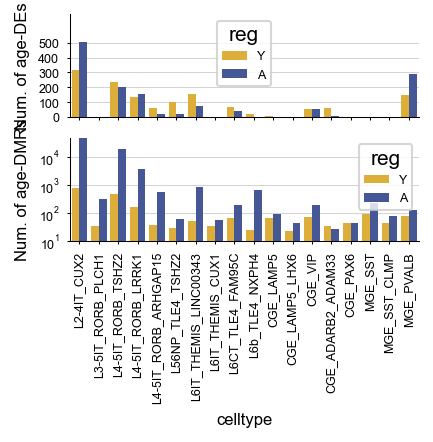

In [5]:
# DEs
fcthres=np.log2(1.2)
pthres=0.05

fulldata=pd.read_csv('../data/ageDEall.tsv.gz',sep='\t',index_col=0)
fulldata=fulldata[fulldata['celltype'].isin(cziplot.level2_order)]
fulldata['logFDR']=-np.log10(fulldata['adj.P.Val'])
fulldata=fulldata.join(gene_meta['chr'])

data=fulldata[(fulldata['adj.P.Val']<pthres) & (np.abs(fulldata['logFC'])>fcthres)]
data.loc[:,'reg']='A'
data.loc[data['logFC']<0,'reg']='Y'
print('total unique  age DEs: ',len(data.index.unique()))
print('  up: ',len(data[(data['logFC']>0)].index.unique()),'down: ',len(data[(data['logFC']<0)].index.unique()))
print('  autosomal age DEs: ',len(data[~(data['chr'].str.contains('[XYM]'))].index.unique()))

print('Exc unique  age DEs: ',len(data[(data['celltype'].isin(cziplot.level2_order[0:10]))].index.unique()))
print('  up: ',len(data[(data['celltype'].isin(cziplot.level2_order[0:10]))&(data['logFC']>0)].index.unique()),'down: ',len(data[(data['celltype'].isin(cziplot.level2_order[0:10]))&(data['logFC']<0)].index.unique()))
print('  autosomal age DEs: ',len(data[~(data['chr'].str.contains('[XYM]'))&(data['celltype'].isin(cziplot.level2_order[0:10]))].index.unique()))
print('Inh unique  age DEs: ',len(data[data['celltype'].isin(cziplot.level2_order[10:18])].index.unique()))
print('  up: ',len(data[(data['celltype'].isin(cziplot.level2_order[10:18]))&(data['logFC']>0)].index.unique()),'down: ',len(data[(data['celltype'].isin(cziplot.level2_order[10:18]))&(data['logFC']<0)].index.unique()))

de_summary=data.groupby(['celltype','reg']).size().to_frame('n').reset_index()

# # DMRs
dmrdata=pd.read_csv('../data/ageDMRall.tsv.gz',sep='\t')
dmrdata=dmrdata[~dmrdata['chr'].str.contains('[YM]')]
dmrdata.loc[:,'reg']='A'
dmrdata.loc[dmrdata['areaStat']<0,'reg']='Y'
dmr_summary=dmrdata.groupby(['celltype','reg']).size().to_frame('n').reset_index() # count number of DMRs 
fig,axs=plt.subplots(2,1,figsize=(3,2),sharex=True,dpi=dpi)

ax=axs[0]
sns.barplot(data=de_summary, x='celltype',y='n',hue='reg',order=cziplot.level2_order,hue_order=['Y','A'],palette=cziplot.age_palette,ax=ax)
ax.set_ylabel('Num. of age-DEs')
ax.set_ylim([0,690])
ax.set_yticks([0,100,200,300,400,500])
ax.grid(axis='y')
ax.tick_params(axis='x', rotation=90)
ax.invert_xaxis()

ax=axs[1]
sns.barplot(data=dmr_summary, x='celltype',y='n',hue='reg',order=cziplot.level2_order,hue_order=['Y','A'],palette=cziplot.age_palette,ax=ax)
ax.set_yscale('symlog')
ax.set_ylabel('Num. of age-DMRs')
ax.grid(axis='y')
ax.set_ylim([1e1,5e4])
ax.tick_params(axis='x', rotation=90)

# compare with GTEx

In [6]:
! wget -O /scratch/Dong_Cell2021_ageDEGs.xlsx https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8208793/bin/ACEL-20-e13357-s002.xlsx  --no-check-certificate

--2024-03-19 13:30:48--  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8208793/bin/ACEL-20-e13357-s002.xlsx
Resolving webproxy.ucsd.edu (webproxy.ucsd.edu)... 132.239.1.231, 132.239.1.230
Connecting to webproxy.ucsd.edu (webproxy.ucsd.edu)|132.239.1.231|:3128... connected.
  Self-signed certificate encountered.
Proxy request sent, awaiting response... 200 OK
Length: 3461293 (3.3M) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘/scratch/Dong_Cell2021_ageDEGs.xlsx’

/scratch/Dong_Cell2 100%[===================>]   3.30M  4.31MB/s    in 0.8s    

2024-03-19 13:30:49 (4.31 MB/s) - ‘/scratch/Dong_Cell2021_ageDEGs.xlsx’ saved [3461293/3461293]



In [7]:
gtex=pd.read_excel('/scratch/Dong_Cell2021_ageDEGs.xlsx',sheet_name='Table S1',skiprows=1)
gtex[gtex['Tissue'].str.contains('Brain')]['Tissue'].value_counts()

Brain - Cortex                               143
Brain - Cerebellum                            43
Brain - Frontal Cortex (BA9)                  28
Brain - Hippocampus                           28
Brain - Hypothalamus                          21
Brain - Cerebellar Hemisphere                 19
Brain - Nucleus accumbens (basal ganglia)     14
Brain - Caudate (basal ganglia)               11
Brain - Amygdala                              10
Brain - Putamen (basal ganglia)                5
Brain - Anterior cingulate cortex (BA24)       4
Brain - Substantia nigra                       1
Name: Tissue, dtype: int64

Text(0.5, 1.0, 'Spearman corr =0.64, p = 7E-15')

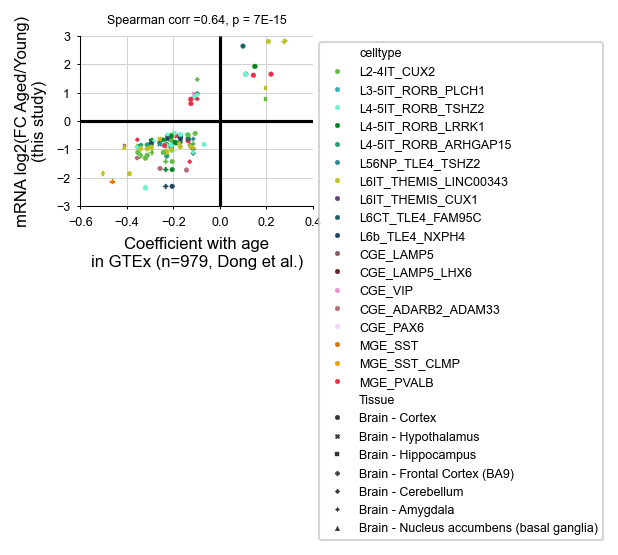

In [8]:
# Merge GTEx DEGs with ours
gtex_age_degs = gtex.merge(data,left_on='Gene name',right_on='gene_name')
gtex_age_degs['RNA logFC sign']=(gtex_age_degs['logFC']>0).map({True:'Up-regulated',False:'Down-regulated'})

df_show = gtex_age_degs[(gtex_age_degs['Tissue'].str.contains('Brain'))&~(gtex_age_degs['Tissue'].str.contains('Hemisphere'))]

fig=plt.figure(figsize=(2,1.5),dpi=dpi)
ax=sns.scatterplot(df_show,x='Coefficient with age',y='logFC',s=5,
                  hue='celltype',hue_order=cziplot.level2_order,palette=cziplot.level2_palette,
                   style='Tissue',
                   edgecolor=None,
                  )
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Coefficient with age\nin GTEx (n=979, Dong et al.)')
ax.set_ylabel('mRNA log2(FC Aged/Young)\n(this study)')
ax.hlines(0,-.6,.4,'k')
ax.vlines(0,-3,3,'k')
ax.grid()
ax.set_xlim([-.6,.4])
ax.set_ylim([-3,3])
r,p=sc.stats.spearmanr(df_show['Coefficient with age'],df_show['logFC'])
ax.set_title(f'Spearman corr ={r:.2f}, p = {p:.0E}',fontsize=6)

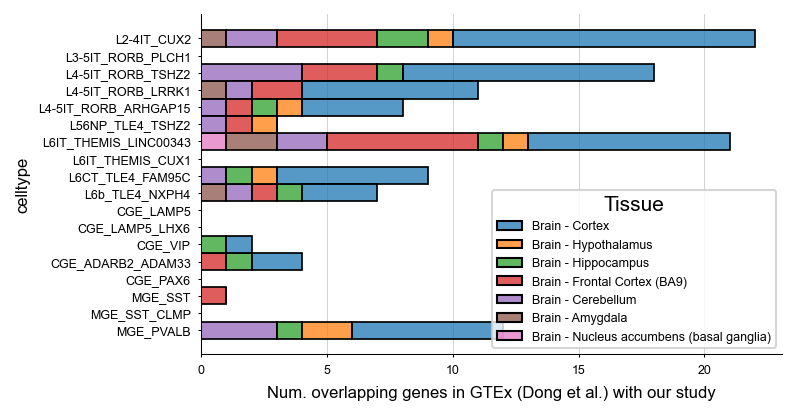

In [9]:
df_show['celltype']=df_show['celltype'].astype('category')
df_show['celltype'] = pd.Categorical(df_show['celltype'],categories=cziplot.level2_order,ordered=True)
fig=plt.figure(figsize=(5,3),dpi=dpi)
ax=sns.histplot(df_show,y='celltype',hue='Tissue',multiple='stack')
ax.set_xlabel('Num. overlapping genes in GTEx (Dong et al.) with our study')
ax.grid(axis='x')

# heatmap

1862  autosomal genes


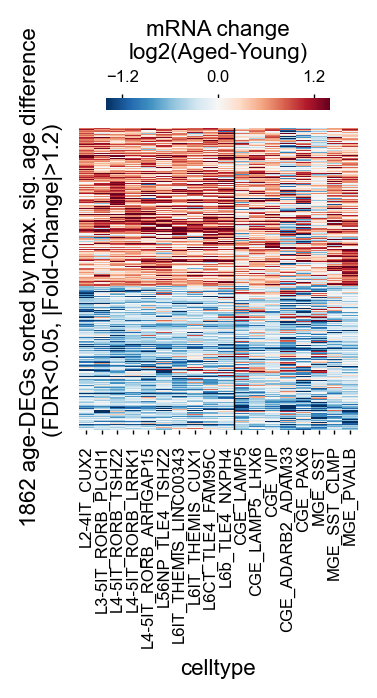

In [10]:
fulldata_df=fulldata.loc[fulldata[~(fulldata['chr'].str.contains('[XYM]'))&(np.abs(fulldata['logFC'])>fcthres)&(fulldata['adj.P.Val']<pthres)].index.unique()]\
.pivot(columns='celltype',values='logFC')
data_df=fulldata[~(fulldata['chr'].str.contains('[XYM]'))&(np.abs(fulldata['logFC'])>fcthres)&(fulldata['adj.P.Val']<pthres)].pivot(columns='celltype',values='logFC')
fulldata_df=fulldata_df[cziplot.level2_order]
print(len(fulldata_df),' autosomal genes')

gene_order=data_df.loc[(data_df.mean(axis=1)>0)].idxmax(axis=1).sort_values(key=lambda x: x.map({c:i for i,c in enumerate(level2_order)})).index.to_list() + \
data_df.loc[(data_df.mean(axis=1)<0)].idxmax(axis=1).sort_values(key=lambda x: x.map({c:i for i,c in enumerate(level2_order)})).index.to_list()
plt.figure(figsize=(1.8,2.5),dpi=200)
ax=sns.heatmap(fulldata_df.fillna(0).loc[gene_order,cziplot.level2_order],
            cbar_kws={'orientation': 'horizontal','location':"top",
                      'label':'mRNA change\nlog2(Aged-Young)','ticks':[-1.2,0,1.2],'shrink':.8},
            vmax=1.4,vmin=-1.4,
            cmap='RdBu_r',center=0,
            xticklabels=True,
            yticklabels=False,
            rasterized=True,
           )
ax.set_ylabel(f' {len(fulldata_df)} age-DEGs sorted by max. sig. age difference\n(FDR<{pthres}, |Fold-Change|>{2**fcthres})')
ax.axvline(x=10,c='k',linewidth=0.5)

Downloading...
From: https://drive.google.com/uc?id=1xholgPWBVz5jnFKhtneph2tgF4dlglF_
To: /scratch/Union_autosomal_ageDMR_mCG.tsv.gz
100%|██████████████████████████████████████| 11.3M/11.3M [00:00<00:00, 96.8MB/s]


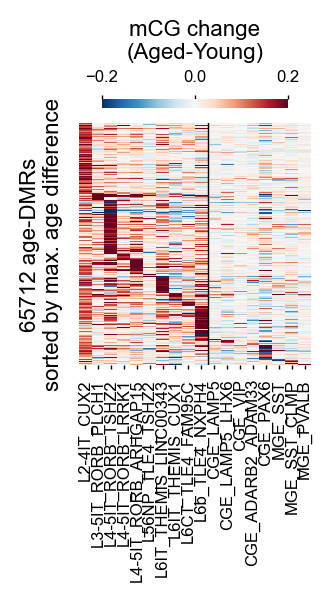

In [11]:
! gdown -O /scratch/Union_autosomal_ageDMR_mCG.tsv.gz  https://drive.google.com/file/d/1xholgPWBVz5jnFKhtneph2tgF4dlglF_/view?usp=drive_link --fuzzy
agedmrs=pd.read_csv('/scratch/Union_autosomal_ageDMR_mCG.tsv.gz',sep='\t',index_col=[0,1,2])
gene_order=agedmrs.abs().idxmax(axis=1).sort_values(key=lambda x: x.map({c:i for i,c in enumerate(level2_order)})).index
plt.figure(figsize=(1.5,2),dpi=200)
ax=sns.heatmap(
            agedmrs.loc[gene_order],
            cbar_kws={'orientation': 'horizontal','location':"top",
                      'label':'mCG change\n(Aged-Young)','ticks':[-0.2,0,0.2],'shrink':.8},
            vmin=-0.2,vmax=0.2,center=0,
            cmap='RdBu_r',
            xticklabels=True,
            yticklabels=False,
            rasterized=True,
           )
ax.set_ylabel(f'{len(agedmrs)} age-DMRs\nsorted by max. age difference')
ax.axvline(x=10,c='k',linewidth=0.5)